In [ ]:
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.random.set_seed(20240327)

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization # from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import Concatenate # from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback # from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator


## 데이터 전처리

```
# 데이터셋에 노이즈가 많다고 가정하고 granular noise를 제거하고자 함
```



**id** - the id of the image

**band_1, band_2** - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Note that these values are not the **normal non-negative integers in image files** since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals **characterized by radar backscatter produced from different polarizations at a particular incidence angle**. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). More background on the satellite imagery can be found [here](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge#Background).

**inc_angle** - the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.

**is_iceberg** - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json.

In [ ]:
def color_composite(data):
  rgb_arrays = []
  for i, row in data.iterrows():
    band_1 = np.array(row['band_1']).reshape(75, 75)
    band_2 = np.array(row['band_2']).reshape(75, 75)
    band_3 = band_1 / band_2

    r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
    g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
    b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

    rgb = np.dstack((r, g, b))
    rgb_arrays.append(rgb)
  return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
  return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel)for item in X])

def smooth(X, sigma):
  return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
  return np.asarray([rgb2gray(item) for item in X])

In [ ]:
train = pd.read_json("/content/drive/MyDrive/24-1-da/train.json")
train.inc_angle = train.inc_angle.replace('na', 0) # 결측치 0으로
train.inc_angle = train.inc_angle.astype(float).fillna(0.0) # 결측치 0으로
train_all = True

train_b = True or train_all #
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [ ]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2 # average of band_1, band_2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x]) # 평면 벡터를 75x75 이미지로

    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')

    if train_b and clean_b: # flag 각각의 조건이 만족되면
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')

    if train_img and clean_img: # 마찬가지로 조건이 만족되면
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x]) # 텐서플로에 적합한 채널 차원으로 변환
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)

    if labeled:
        y = np.array(frame["is_iceberg"]) # labled가 트루면, 'is_iceberg' 칼럼 추출
    else:
        y = None
    return y, band, images

In [ ]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


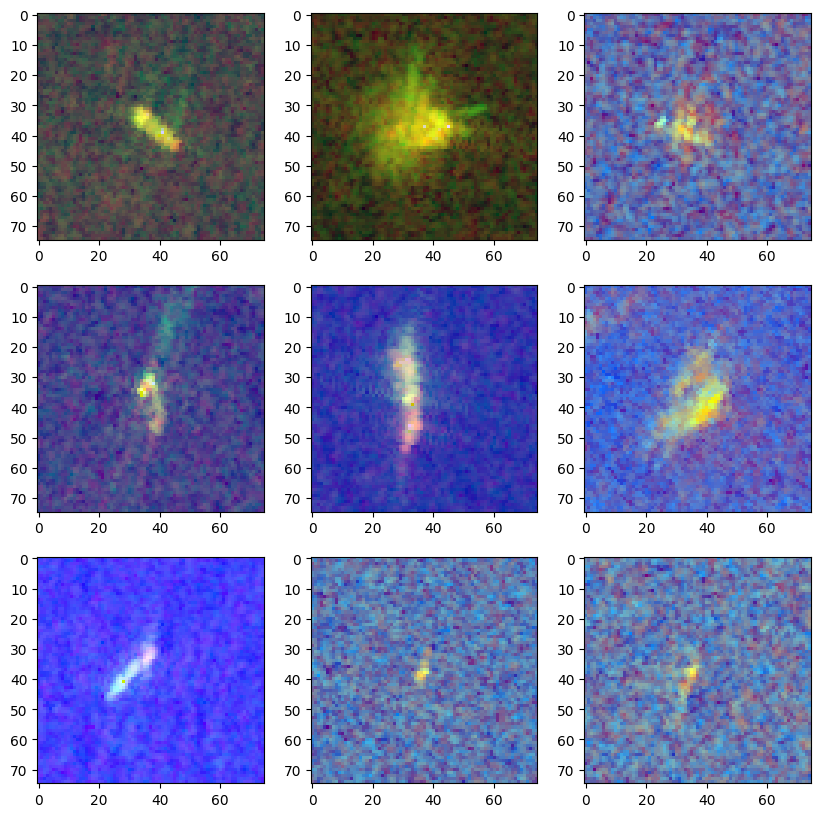

In [ ]:
fig = plt.figure(200, figsize = (10, 10))
random_indices = np.random.choice(range(len(X_images)), 9, False) # 9개 선택, False = 중복 허용 안함(unique한 값만)
subset = X_images[random_indices]
for i in range(9):
  ax = fig.add_subplot(3, 3, i + 1) # 3X3 그리드, i+1이 포지션
  ax.imshow(subset[i])
plt.show()

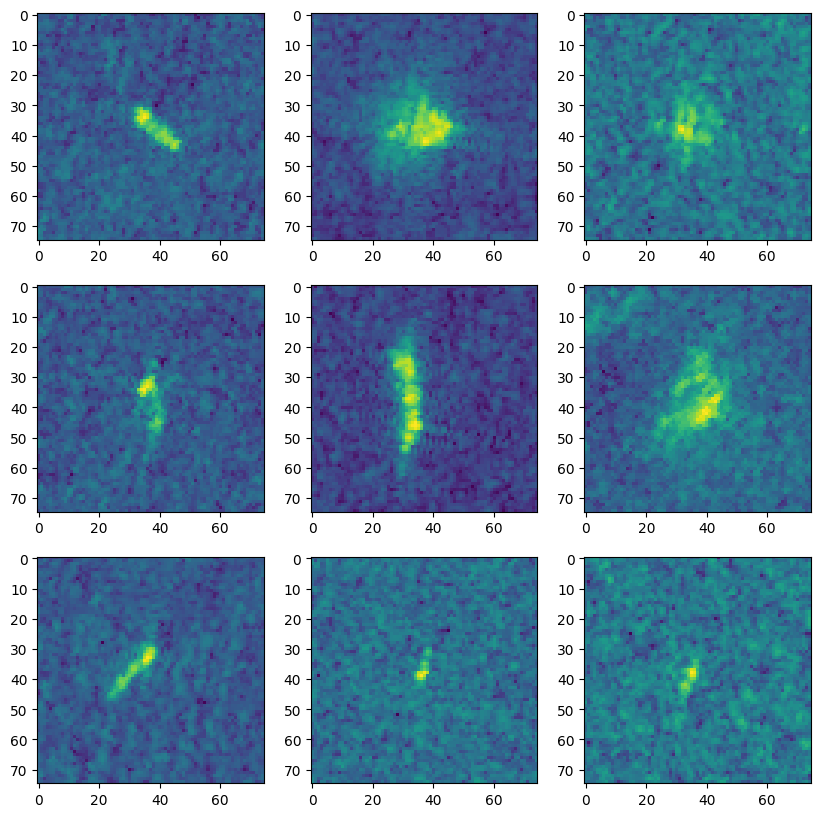

In [ ]:
fig = plt.figure(202, figsize=(10, 10))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indices]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

<ipython-input-2-652c55c28c0b>:17: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel)for item in X])


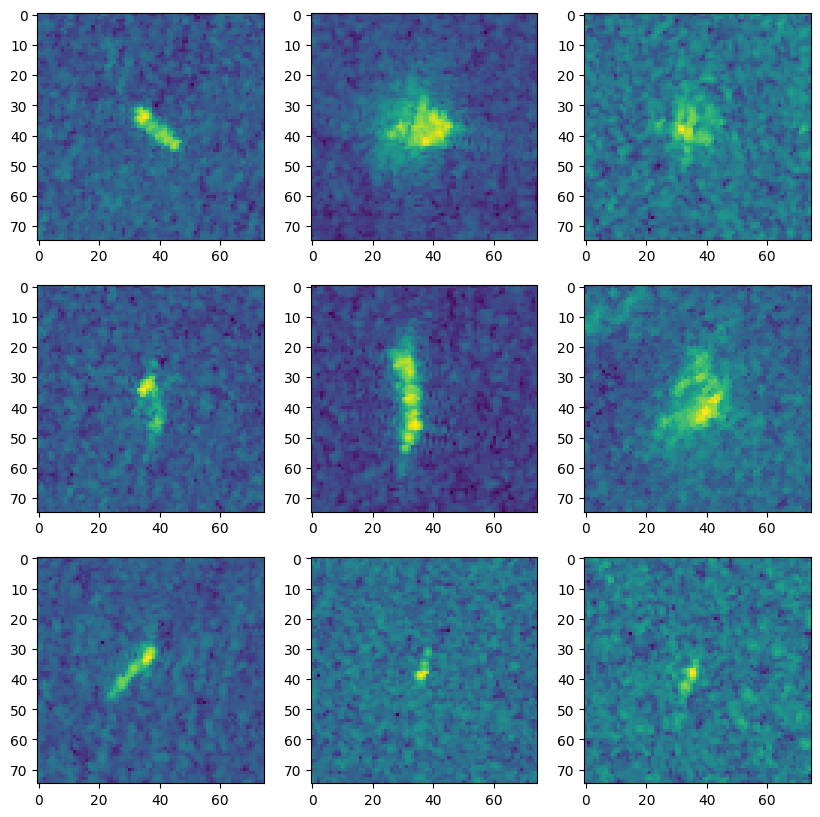

In [ ]:
# denoising 추가
fig = plt.figure(202, figsize=(10, 10))
subset = np.asarray(band_1_x)[random_indices]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

<ipython-input-2-652c55c28c0b>:17: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel)for item in X])


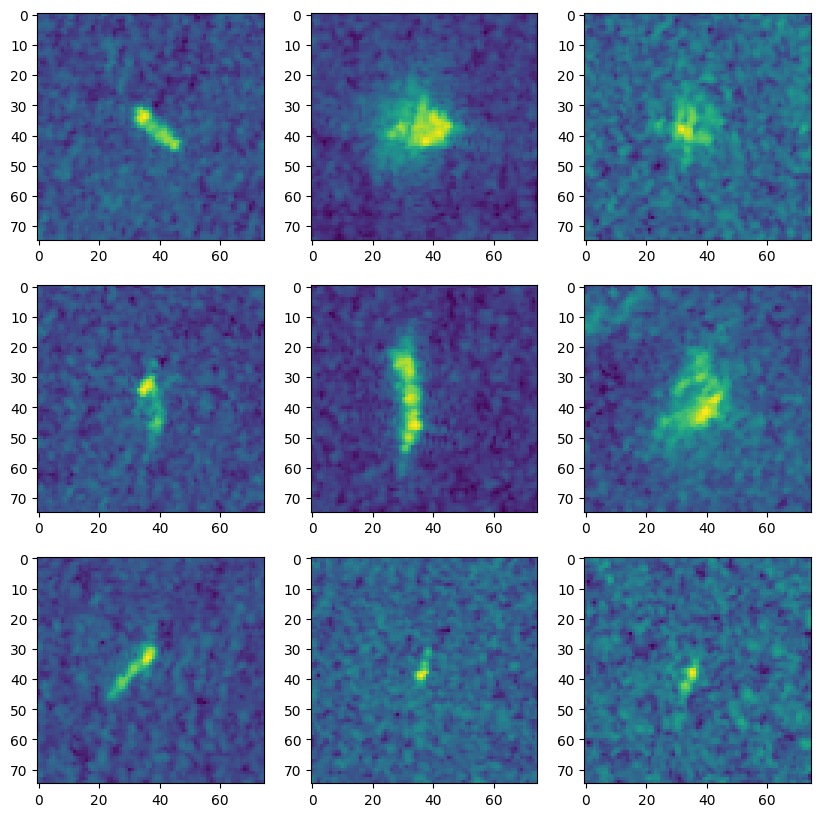

In [ ]:
# smoothing까지
fig = plt.figure(202, figsize=(10, 10))
subset = np.asarray(band_1_x)[random_indices]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

## 모델
- 3개의 CNN(2: basic, 1: combined)

In [ ]:
def get_model_notebook(learning_rate, channels, relu_type='relu'): # 'lr' is deprecated, use 'learning_rate' instead
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(learning_rate=learning_rate) # decay is deprecated
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [ ]:
def combined_model(m_b, m_img, learning_rate, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # 모델 합치기
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # decay is deprecated
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
# 같은 gen 함수를 각 I1, I2에 적용하는 건 안될까?
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0]) # I1i와 I2i의 data augmentation이 동일하게 적용됐는지 확인
        yield [I1i[0], I2i[1]], I1i[1]

In [ ]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [ ]:
# 개별 모델 훈련
def gen_model_weights(learning_rate, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(learning_rate, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [ ]:
# 세 모델 모두 훈련
def train_models(dataset, learning_rate, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(learning_rate, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(learning_rate, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, learning_rate/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

- 모델 파라미터
- 3개의 세트로 저장해야 함

In [ ]:
# 작성자가 찾은 Best parameters
# epochs : 250
# learning rate : 8e-5
# batch size : 32
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)

Training bandwidth network
Epoch 1/50


<ipython-input-36-24bccf428fa4>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,


38/38 [==============================] - 8s 122ms/step - loss: 0.6548 - accuracy: 0.5905 - val_loss: 1.9558 - val_accuracy: 0.5253
Epoch 2/50
38/38 [==============================] - 2s 51ms/step - loss: 0.6226 - accuracy: 0.6158 - val_loss: 2.8553 - val_accuracy: 0.5253
Epoch 3/50
39/38 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6550

38/38 [==============================] - 6s 156ms/step - loss: 0.6032 - accuracy: 0.6550 - val_loss: 0.8880 - val_accuracy: 0.5207
Epoch 4/50
38/38 [==============================] - 4s 105ms/step - loss: 0.5751 - accuracy: 0.6868 - val_loss: 0.5675 - val_accuracy: 0.6820
Epoch 5/50
38/38 [==============================] - 2s 50ms/step - loss: 0.5240 - accuracy: 0.7349 - val_loss: 0.7475 - val_accuracy: 0.4839
Epoch 6/50
38/38 [==============================] - 2s 52ms/step - loss: 0.5065 - accuracy: 0.7480 - val_loss: 0.7423 - val_accuracy: 0.5161
Epoch 7/50
38/38 [==============================] - 3s 73ms/step - loss: 0.4720 - accuracy: 0.7716 - val_loss: 0.5942 - val_accuracy: 0.6313
Epoch 8/50
38/38 [==============================] - 3s 79ms/step - loss: 0.4424 - accuracy: 0.7953 - val_loss: 0.7236 - val_accuracy: 0.5668
Epoch 9/50
38/38 [==============================] - 3s 66ms/step - loss: 0.4252 - accuracy: 0.8091 - val_loss: 0.6075 - val_accuracy: 0.6636
Epoch 10/50
38/38 [===

<ipython-input-36-24bccf428fa4>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,


38/38 [==============================] - 7s 109ms/step - loss: 0.6339 - accuracy: 0.6330 - val_loss: 0.6850 - val_accuracy: 0.5760
Epoch 2/50
38/38 [==============================] - 6s 149ms/step - loss: 0.5421 - accuracy: 0.7162 - val_loss: 0.6802 - val_accuracy: 0.5253
Epoch 3/50
38/38 [==============================] - 2s 49ms/step - loss: 0.5021 - accuracy: 0.7374 - val_loss: 0.6992 - val_accuracy: 0.5346
Epoch 4/50
38/38 [==============================] - 2s 51ms/step - loss: 0.4676 - accuracy: 0.7635 - val_loss: 0.7736 - val_accuracy: 0.5300
Epoch 5/50
38/38 [==============================] - 4s 104ms/step - loss: 0.4813 - accuracy: 0.7667 - val_loss: 0.5961 - val_accuracy: 0.6820
Epoch 6/50
38/38 [==============================] - 3s 89ms/step - loss: 0.4766 - accuracy: 0.7561 - val_loss: 0.6204 - val_accuracy: 0.6267
Epoch 7/50
38/38 [==============================] - 2s 50ms/step - loss: 0.4535 - accuracy: 0.7871 - val_loss: 0.7115 - val_accuracy: 0.5853
Epoch 8/50
38/38 [===

<ipython-input-38-2ccba9133de5>:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),


Epoch 1/30
45/45 [==============================] - 16s 218ms/step - loss: 0.3212 - accuracy: 0.8545 - val_loss: 0.2359 - val_accuracy: 0.8696
Epoch 2/30
45/45 [==============================] - 9s 214ms/step - loss: 0.2787 - accuracy: 0.8753 - val_loss: 0.2281 - val_accuracy: 0.8882
Epoch 3/30
45/45 [==============================] - 10s 228ms/step - loss: 0.2589 - accuracy: 0.8912 - val_loss: 0.2165 - val_accuracy: 0.9006
Epoch 4/30
45/45 [==============================] - 4s 84ms/step - loss: 0.2601 - accuracy: 0.8863 - val_loss: 0.2194 - val_accuracy: 0.8820
Epoch 5/30
45/45 [==============================] - 11s 253ms/step - loss: 0.2457 - accuracy: 0.8947 - val_loss: 0.2140 - val_accuracy: 0.9006
Epoch 6/30
45/45 [==============================] - 10s 231ms/step - loss: 0.2468 - accuracy: 0.8919 - val_loss: 0.1961 - val_accuracy: 0.8882
Epoch 7/30
45/45 [==============================] - 3s 75ms/step - loss: 0.2483 - accuracy: 0.8988 - val_loss: 0.2091 - val_accuracy: 0.9130
Epoc

In [ ]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json("/content/drive/MyDrive/24-1-da/test.json")
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

    submission.to_csv("./submission.csv", index=False)
    print('Done')

Reading test dataset
Denoising and reshaping
RGB done
Predicting
